# Koopman delay embeddings assesment process
## 1 - Data gathering

In [18]:
import numpy as np
from numpy import random
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Pendulum model-free control with references $R_1$ and $R_2$

(<matplotlib.legend.Legend at 0x13708f008b0>,
 <matplotlib.legend.Legend at 0x1370bfbf5e0>)

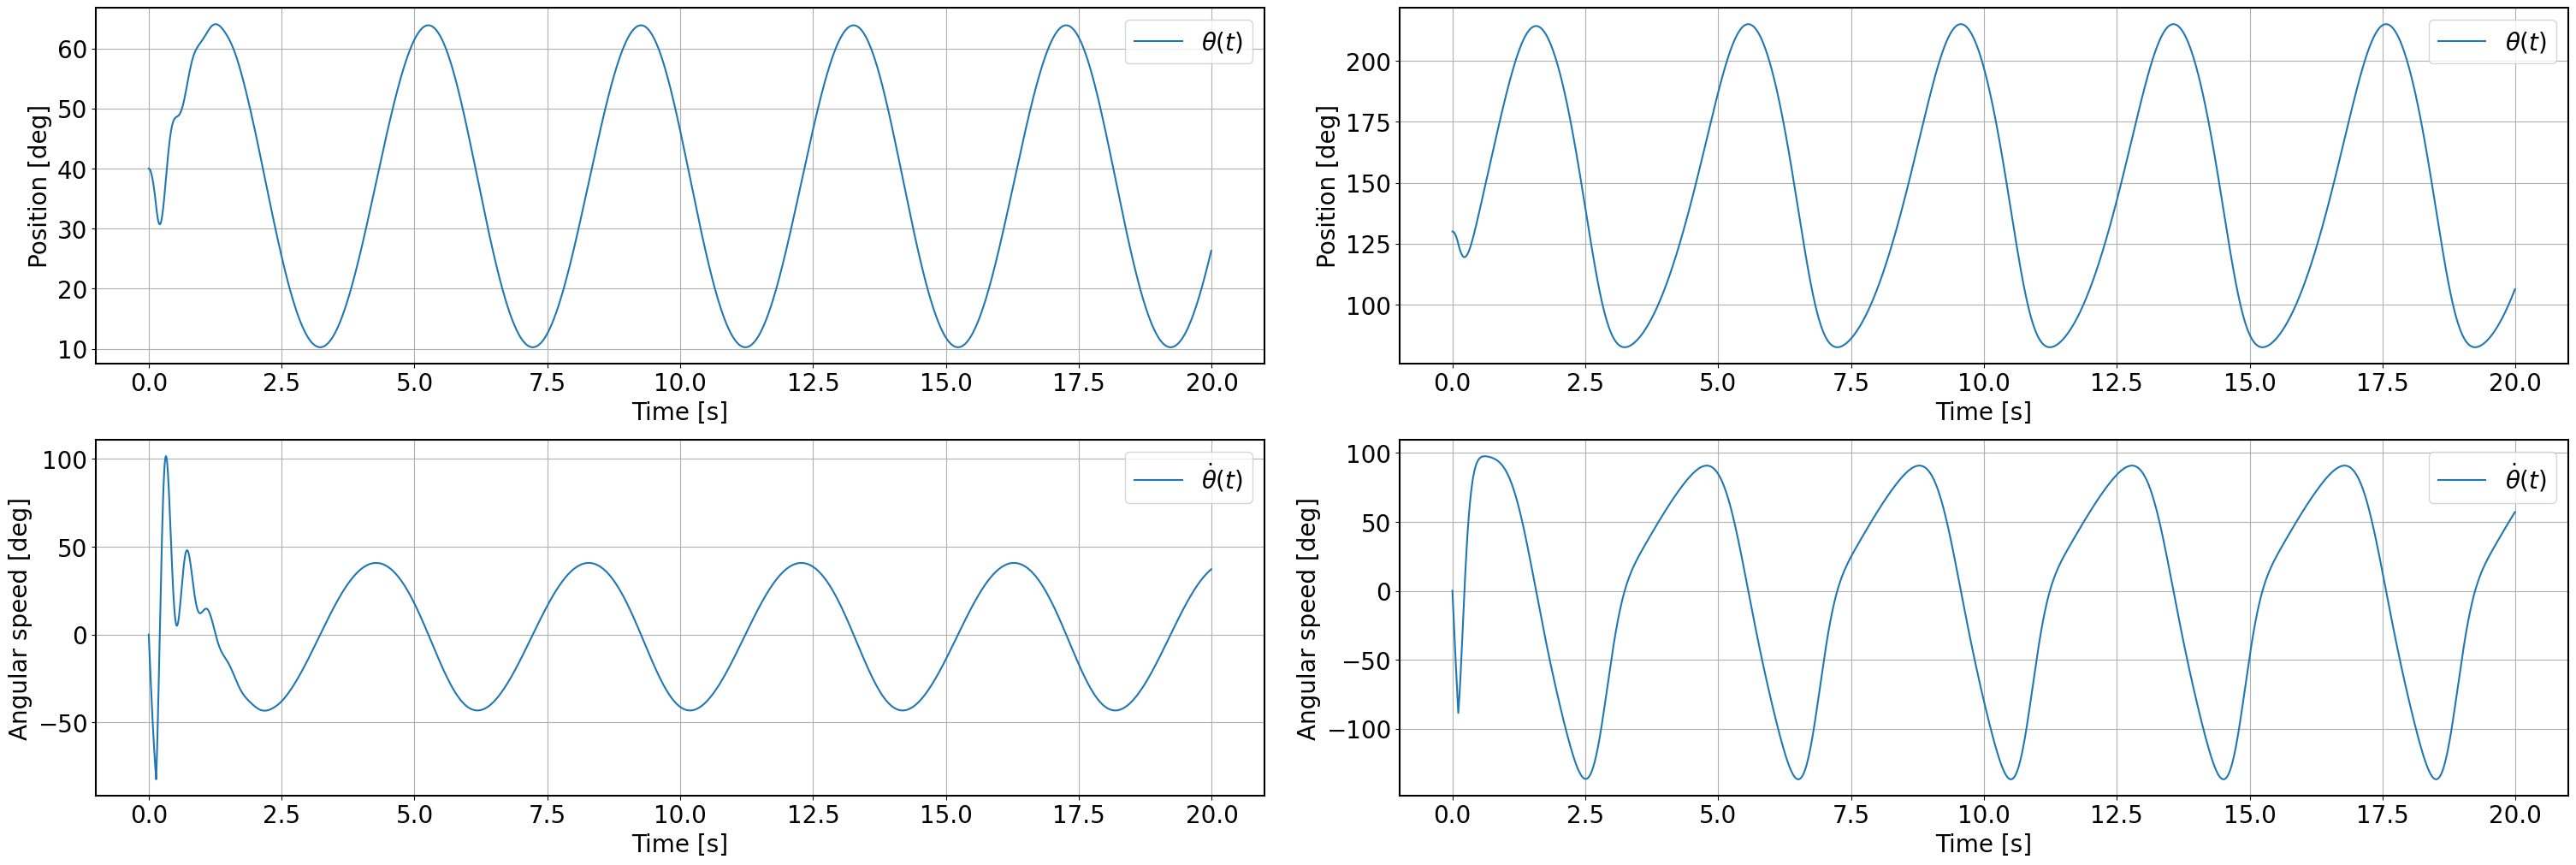

In [5]:
# Pendulum instance
dt = 1e-2
pend1 = SimplePendulum(mass=1, length=1, time=np.arange(0,20,dt), X0=np.array([deg2rad(40),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=np.arange(0,20,dt), X0=np.array([deg2rad(130),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude = 30 # deg
pend1.ref = sineReference(pend1.N, pend1.T_ref, [deg2rad(40-amplitude), deg2rad(40+amplitude)])
pend2.ref = sineReference(pend1.N, pend2.T_ref, [deg2rad(130-amplitude), deg2rad(130+amplitude)])

# Simulation

for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 10, 0, 50, pend1.dt, 13)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 10, 0, 33, pend2.dt, 10)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

## Linear dynamics learning

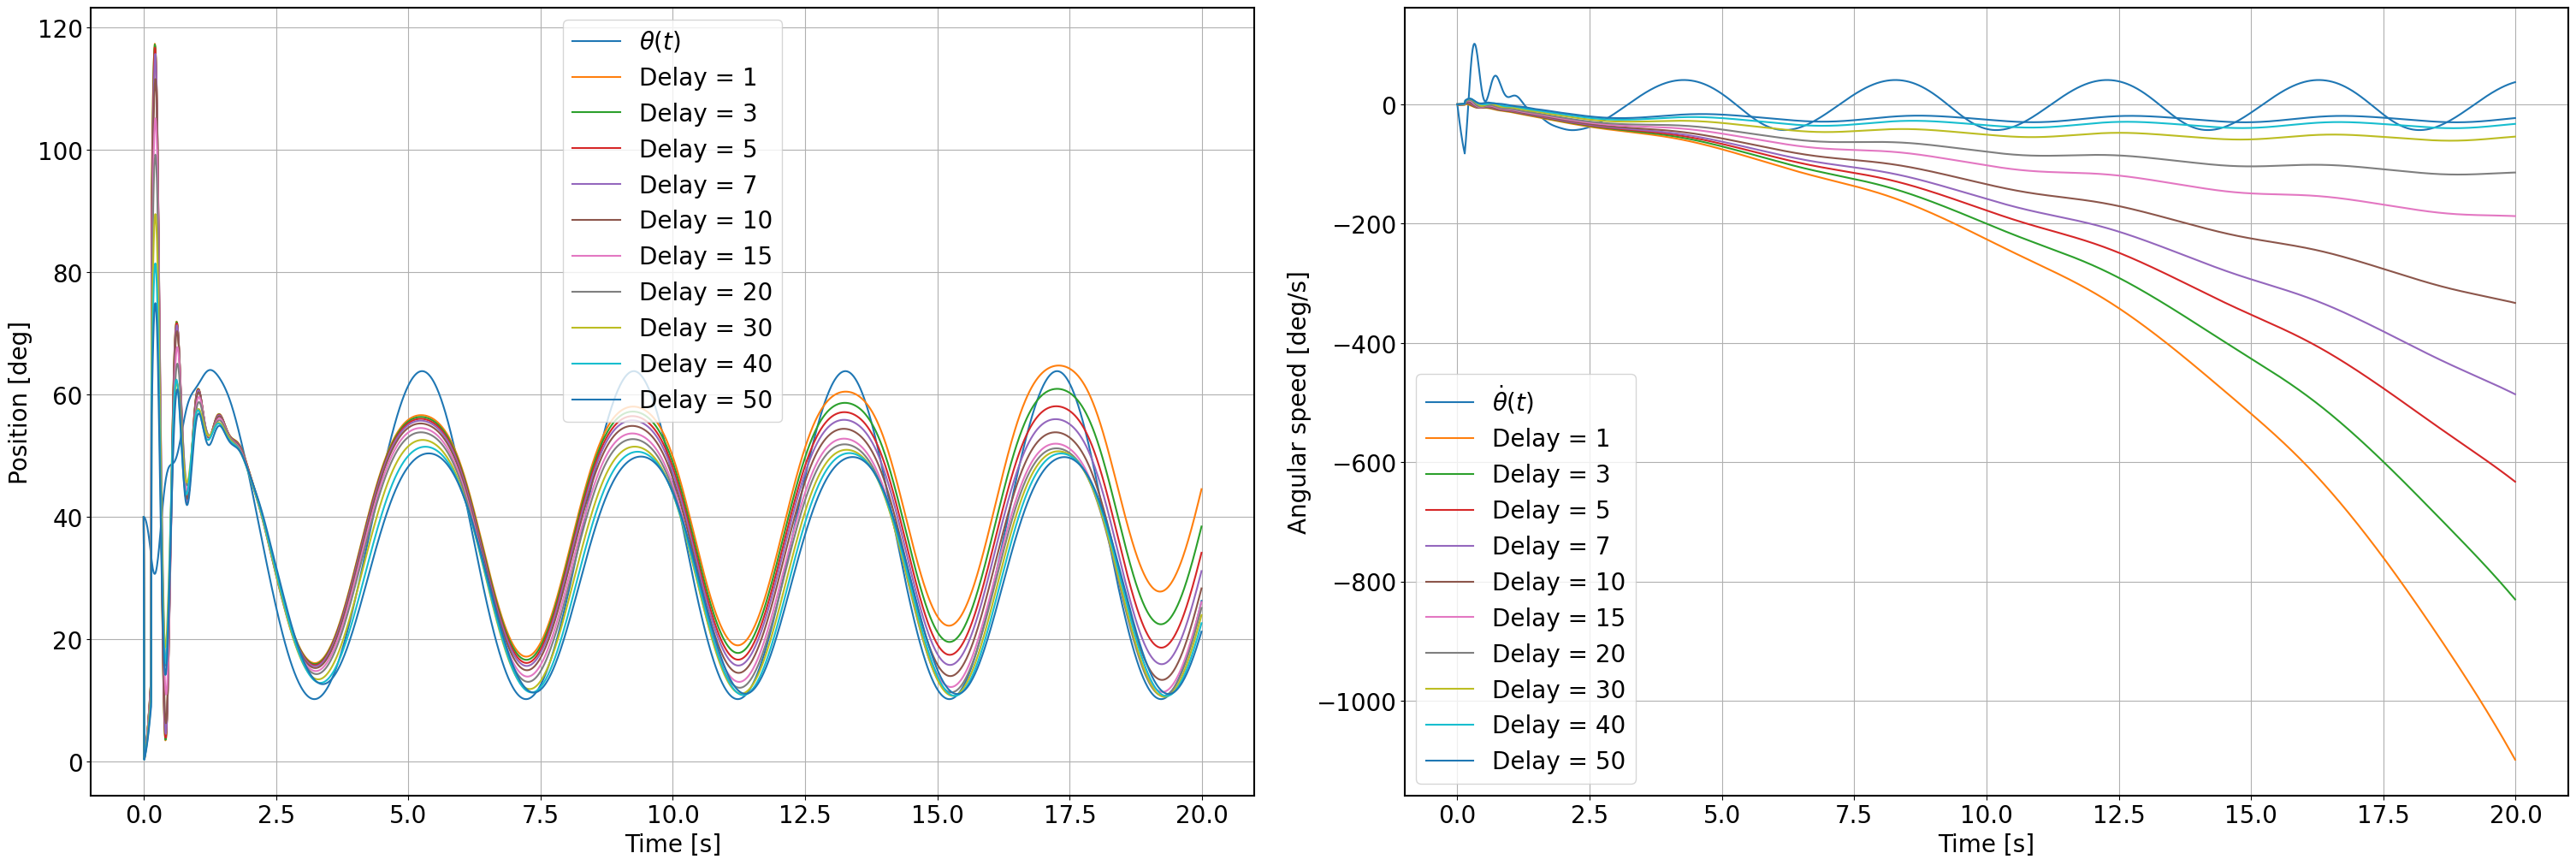

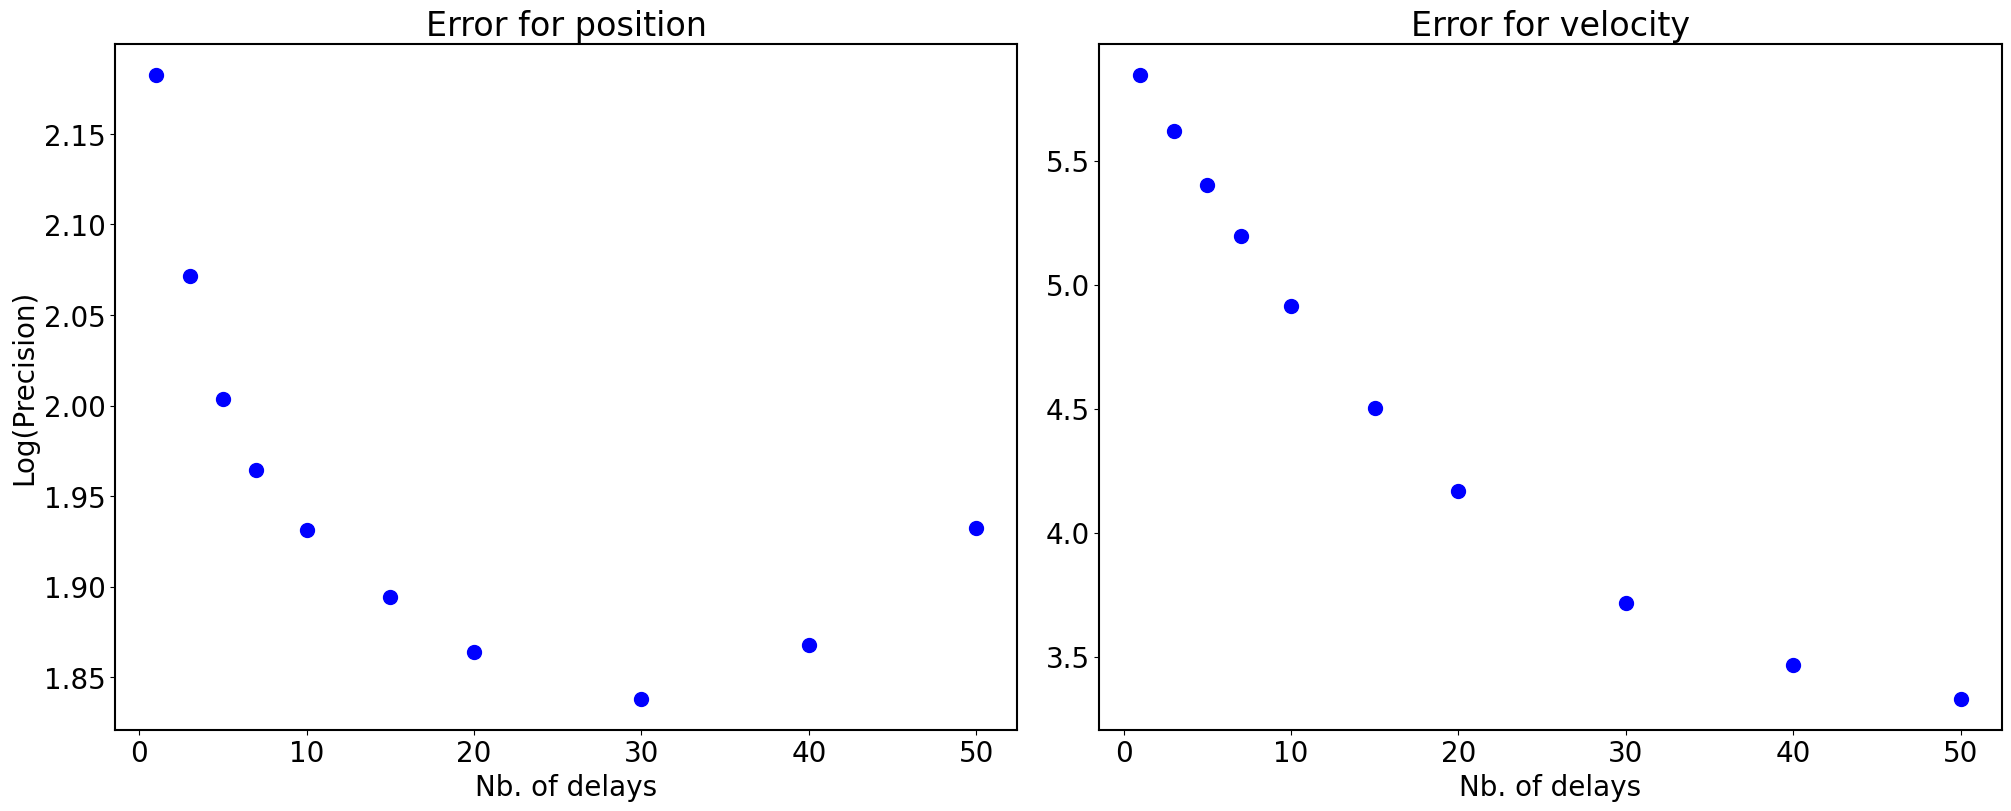

In [15]:
# Parameters
pend = pend1
horizon = np.int(pend.N/4)
nb_delay = [1,3,5,7,10,15,20,30,40,50]
nb_plots = len(nb_delay)
explained_var = .1 # Truncation of the U, Sigma and V matrices

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(30,10))
fig2, ax2 = plt.subplots(1, 2, constrained_layout = True, figsize=(20,8))
ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()
for i in range(nb_plots):
    tau = nb_delay[i]
    f1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
    f1.SVD(truncation_ratio=explained_var)
    f1.truncate(rank=f1.optimal_truncation)
    f1.computeTrajectory(pend.X0, pend.U)
    f1.computePrecision(pend.X)
    
    ax[0].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[0,:]), label='Delay = '+str(tau))
    ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[1,:]), label='Delay = '+str(tau))
    ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
    ax[1].grid()
    ax[1].legend()
    
    ax2[0].plot(tau, np.log(f1.precision[0]),'-o', markersize=10, color='b'), ax2[0].set_title('Error for position'), ax2[0].set_xlabel('Nb. of delays'), ax2[0].set_ylabel('Log(Precision)')
    ax2[1].plot(tau, np.log(f1.precision[1]),'-o', markersize=10, color='b'), ax2[1].set_title('Error for velocity'), ax2[1].set_xlabel('Nb. of delays')
    ax2[0].grid(), ax2[1].grid()

Keep the delay $\tau=30$ with an explained variance of $10$ % since the precision is $\approx 1.85$.

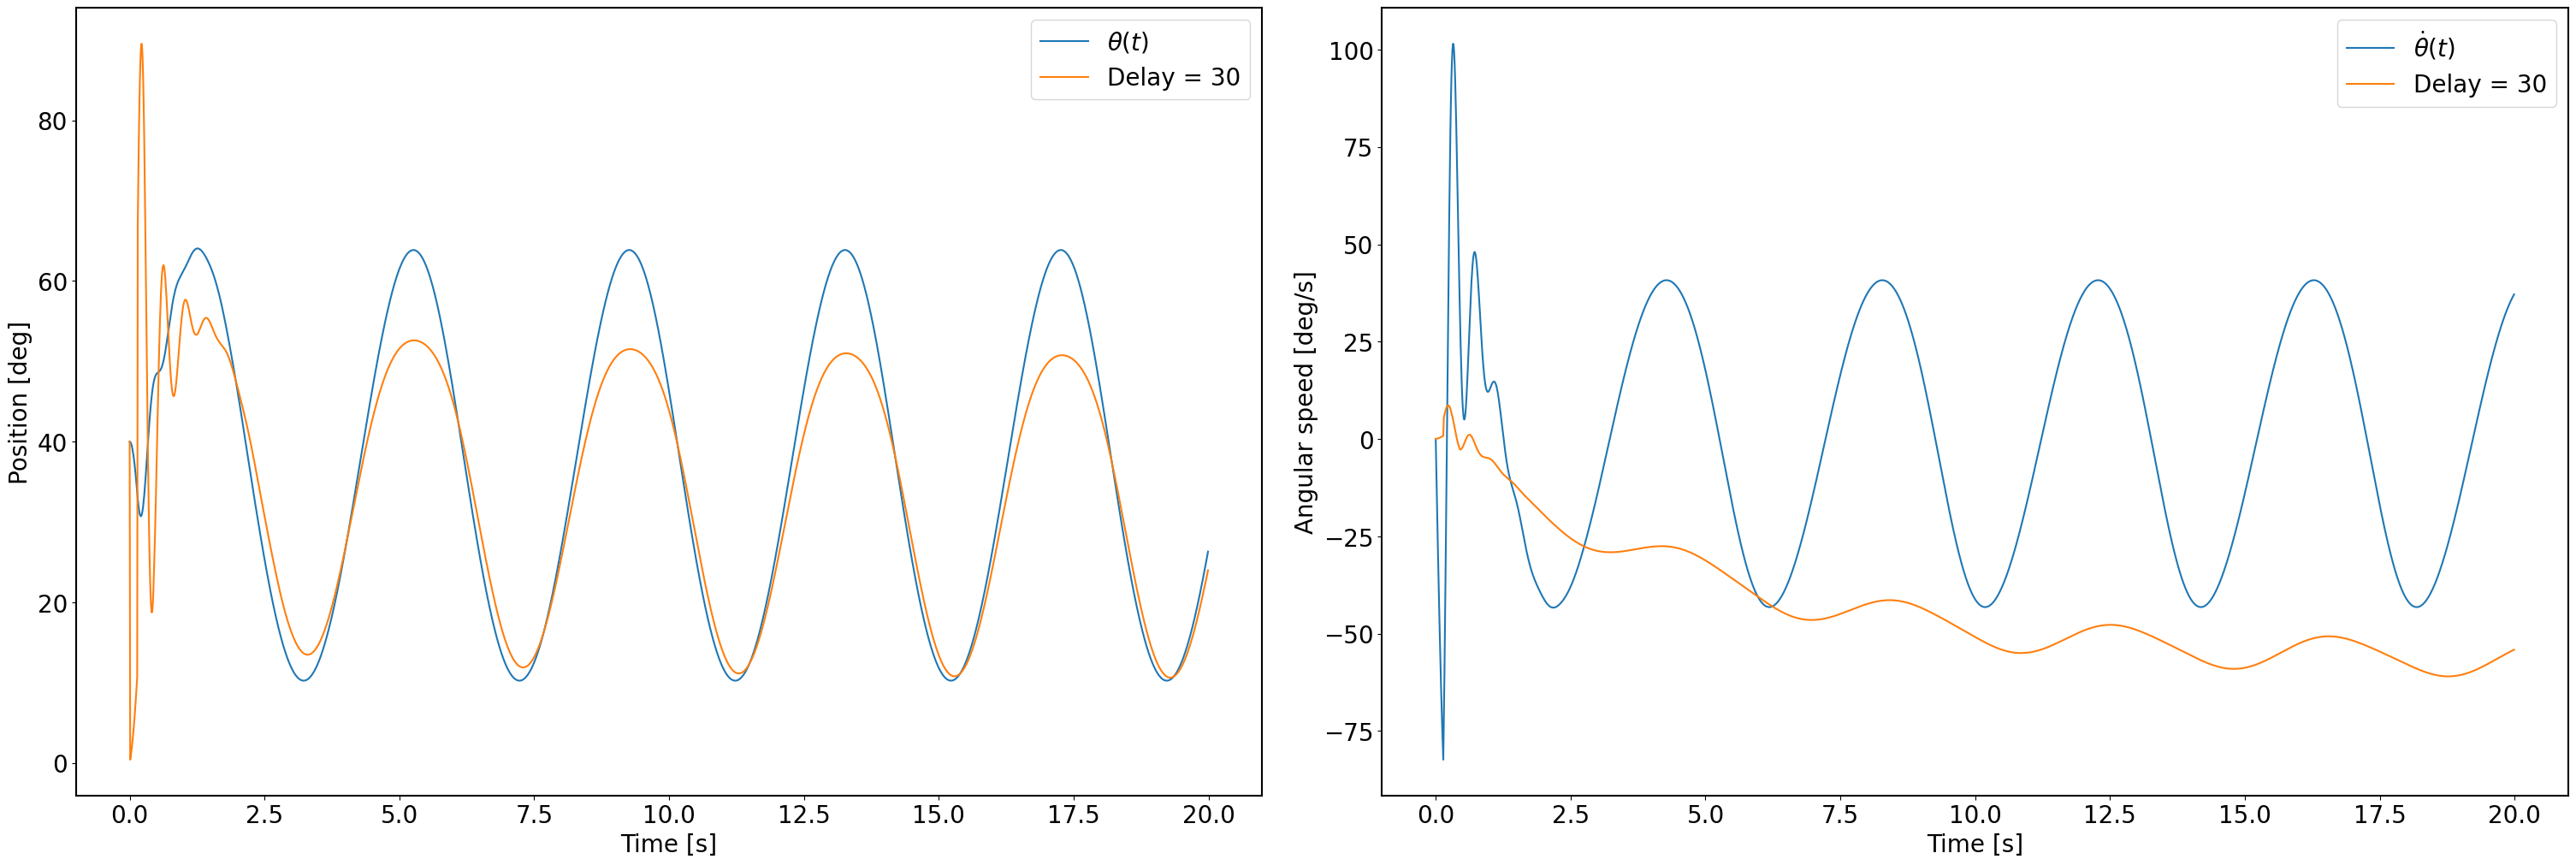

In [16]:
tau = 30
f1 = DelayedLeastSquare(pend.X, tau, horizon, pend.U[:], nb_u=1)
f1.SVD(truncation_ratio=.1)
f1.truncate(rank=f1.optimal_truncation)
f1.computeTrajectory(pend.X0, pend.U)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(30,10))

ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

ax[0].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[0,:]), label='Delay = '+str(tau))
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T[:len(pend.T)], rad2deg(f1.Traj[1,:]), label='Delay = '+str(tau))
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

Train the LQR with the dynamics found with delay embeddings in order to make the rollout of some trajectory, which will then serve as a reference for our model-free controller.

In [23]:
LQR1 = LQR_Transform(f1, pend)
LQR1.LQR_Instance()
LQR1.LQR_setParameters(u_std=-2., x_std=1e4)

LQR1.LQR.ricatti()

### Make LQR rollout

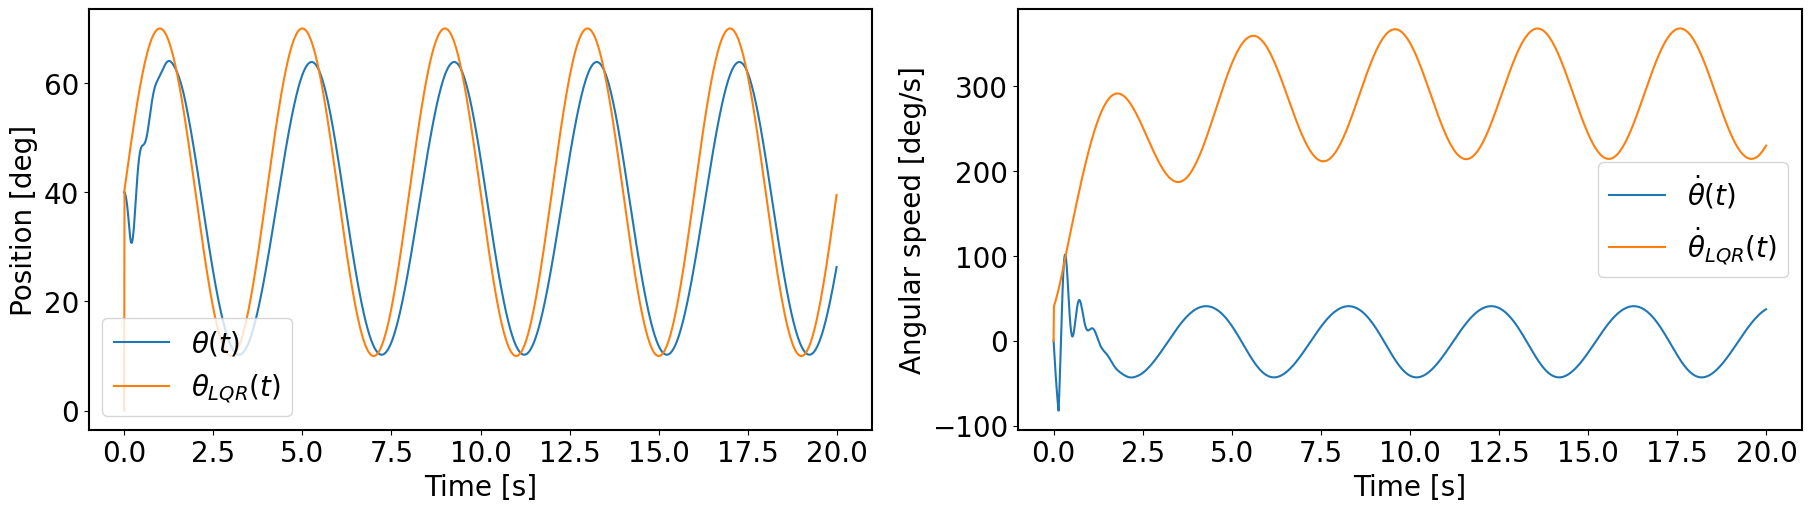

In [27]:
# Simulate the closed-loop system
X0 = np.zeros((10,2*LQR1.tau))
LQR1.LQR_rollout(X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,5))

ax[0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

ax[0].plot(pend.T, rad2deg(LQR1.xs_mean[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend.T, rad2deg(LQR1.xs_mean[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg/s]')
ax[1].grid()
ax[1].legend()

### Model-free control with LQR trajectory as a reference